In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

from scipy.integrate import quad
def integral(x): 
    return np.sqrt(1-v**2) * 1/(1-v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

#n_days = np.array([126000, 212400, 298800, 385200])/86400
#n_days = np.array([1.43, 2.42, 3.41, 4.4])
#n_days = np.array([1.43, 2.42, 3.45, 4.4, 5.4])

#beta, doppler = np.loadtxt('doppler_wo_prolate.txt')
#inter = interp1d(beta, doppler)

beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta1, doppler1)

#beta1, doppler1 = np.loadtxt('doppler_wo_prolate_use_to_the_fourth.txt')
#inter = interp1d(beta1, doppler1)
beta1, doppler1 = np.loadtxt('doppler_with_cossin.txt')
inter = interp1d(beta1, doppler1)

#beta, doppler = np.loadtxt('doppler_incl_temp_40.txt')
#inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #delta = (1-vphot**2)**(1/2) * 1/(1-vphot)
    #delta = (1-vphot**2)**(-1/2) * (1-vphot)
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc




In [12]:
dists = np.linspace(40,50,1000)

0.2798932114605146
Lum_dist =  43.28474781388049 + 0.3368947764158321 - 0.3294684750202208
<Parameter 've', value=0.3127667868694095 +/- 0.0467, bounds=[0:1]>
1.3391756106371648e-29
0.24808001429652052
Lum_dist =  43.04923268832478 + 0.3519155576201882 - 0.34638125973149414
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29


NameError: name 'd_theta_jn' is not defined

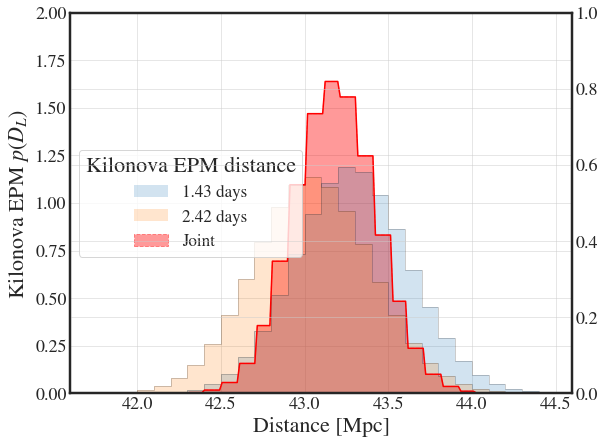

In [3]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=150, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=150, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance [Mpc]'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h[1][1]-h[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='red', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)

combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')

plt.legend(frameon=True, fontsize=17, loc=6,  title="Kilonova EPM distance")

y_max = 2
ax.set_ylim(0,y_max)

ax2 = ax.twinx()
lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/8)
#ax.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW prior', ls='-', color='green')
#ax.plot(dists, y/norm, label='GW prior + VLBI', ls='--', color='green')
plt.grid(False)
plt.xlim(30.1, 49)
ax2.ticklabel_format(style='plain')
ax.ticklabel_format(style='plain')
plt.ylabel(r'$p(D_L)$')#"", color='green')
#plt.yticks(color='green')

#plt.yscale('log'), plt.ylim(0.005, 5)


# added these three lines
#lns = lns1+lns2+lns3
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=2, frameon=True, fontsize=20)

#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=False, fontsize=17, loc=1)

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/8); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.2**2)*np.exp(-(42.9-dists)**2/(2*3.3**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(39.6-dists)**2/(2*3.5**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=False, fontsize=17, loc=2, 
          title = 'Redshift Distance')
#plt.savefig('Pictures/dl_dist_13.png', dpi=300)


In [36]:
lines

0.2798932114605146
Lum_dist =  43.285805516095536 + 0.3362863221541019 - 0.32982484433429704
<Parameter 've', value=0.3127667868694095 +/- 0.0467, bounds=[0:1]>
1.3391756106371648e-29
0.24808001429652052
Lum_dist =  43.049178454729855 + 0.35244324159150153 - 0.34548154695666256
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29


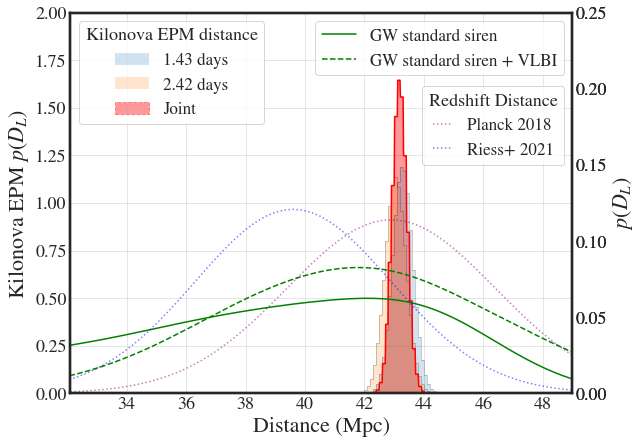

In [8]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=150, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=150, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h[1][1]-h[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='red', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
#combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")
y_max = 2; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/8); plt.grid(False); plt.xlim(32.1, 49)
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/8); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(39.6-dists)**2/(2*3.3**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
          loc = (0.7,0.6), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

#plt.savefig('Pictures/dl_dist_15.png', dpi=300)


0.27768223610679355
Lum_dist =  42.827139745498016 + 0.5070299983795223 - 0.43711504219584185
<Parameter 've', value=0.07449505547902187 +/- 0.00639, bounds=[0:1]>
1.3404076532489784e-29
0.24808001429652052
Lum_dist =  43.04880723036825 + 0.3936461859440996 - 0.3854092156804967
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29


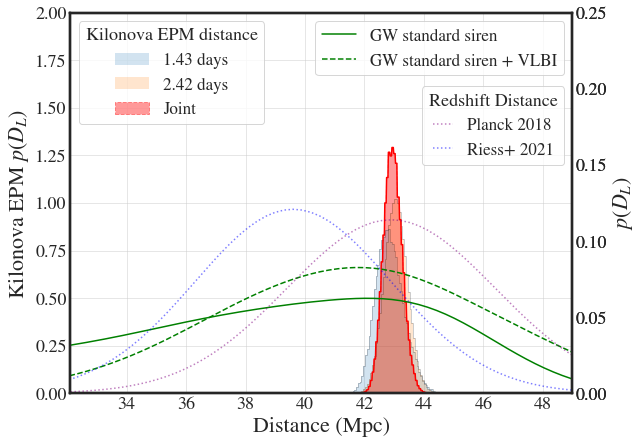

In [11]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_with_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=250, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h[1][1]-h[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='red', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
#combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")
y_max = 2; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/8); plt.grid(False); plt.xlim(32.1, 49)
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/8); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(39.6-dists)**2/(2*3.3**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
          loc = (0.7,0.6), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

#plt.savefig('Pictures/dl_dist_15.png', dpi=300)


0.2778490294630044
Lum_dist =  42.9328483247013 + 1.0255170667679394 - 1.013886443055739
<Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>
1.3338150746859284e-29
0.24758561888175917
Lum_dist =  43.23684909924713 + 0.46217429655283837 - 0.4551644163526589
<Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>
2.752046990957482e-29


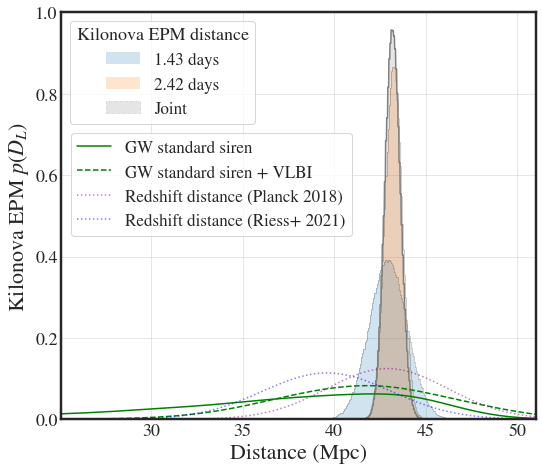

In [10]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(8,7))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
#multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
scale = [0.016, 0.004, 0.016] #[0.016, 0.018, 0.016]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))

    #*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=250, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h[1][1]-h[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='grey', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='grey', ls='--', alpha=0.2, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
#combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
y_max = 1.; ax.set_ylim(0.0,y_max)
#plt.yscale('log')
plt.xlim(25.1, 51)


ax.ticklabel_format(style='plain')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")


ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0.0,y_max), ax2.set_yticks([])
#ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
#plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc = (0.02, 0.55))

#plt.fill
#lines2 = []
#ax3 = ax.twinx(); 
#ax3.set_ylim(0,y_max);
#ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines += ax2.plot(dists, 1/np.sqrt(2*np.pi*3.2**2)*np.exp(-(42.9-dists)**2/(2*3.3**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines += ax2.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(39.6-dists)**2/(2*3.5**2)), label='Redshift distance (Riess+ 2021)', 
          ls='dotted', color='blue'  , alpha=0.5)
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI', 
                   'Redshift distance (Planck 2018)', 'Redshift distance (Riess+ 2021)'], frameon=True, fontsize=17, loc = (0.02, 0.45))

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
#plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
#          loc = (0.7,0.62), #for left loc=(0.02,0.485), 
#          title = 'Redshift Distance', handlelength=1.2)

plt.tight_layout()
#plt.savefig('Pictures/dl_dist_H0_paper.png', dpi=300)


In [23]:
1.0208/42.935

0.023775474554559216

In [7]:
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
sigma, mu

(0.7524419420482725, 43.072119026679445)

In [8]:
0.75/43

0.01744186046511628

0.27793590677592556
Lum_dist =  40.68282995318143 + 0.34931142088893097 - 0.35408290707052714
<Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>
1.3338150746859284e-29
0.24759563525437875
Lum_dist =  41.24307835291452 + 0.37963402785081257 - 0.3731372368380903
<Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>
2.752046990957482e-29


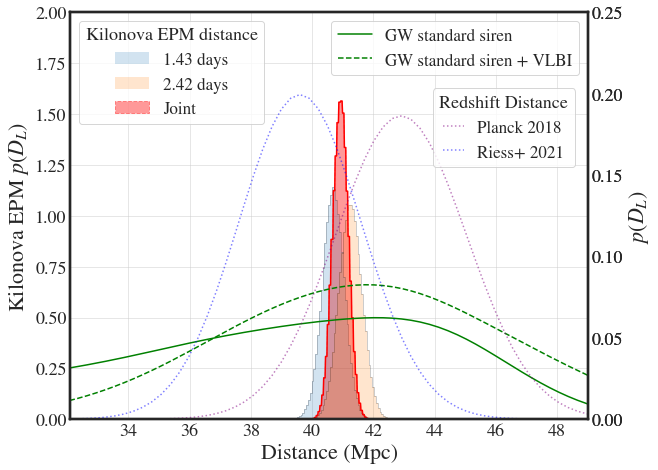

In [15]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9.6,7))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
#multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=250, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h[1][1]-h[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='red', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h[1][1:]+h[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
#combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")
y_max = 2; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/8); plt.grid(False); plt.xlim(32.1, 49)
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/8); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*2.14**2)*np.exp(-(42.9-dists)**2/(2*2.14**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*2**2)*np.exp(-(39.6-dists)**2/(2*2**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
          loc = (0.7,0.62), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

plt.tight_layout()
#plt.savefig('Pictures/cossin_dl_dist.png', dpi=300)


In [17]:
mu, sigma

(43.07919155317211, 0.27156373358684466)

# mu, sigma

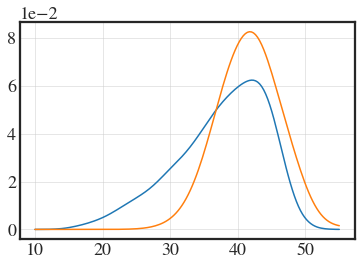

In [13]:
# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./Inclination/figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./Inclination/figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./Inclination/figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./Inclination/figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

theta_jns = XX[0, :]; 
dists = YY[:, 0]

d_theta_jn = theta_jns[1] - theta_jns[0]
ourprior = 1/np.sqrt(2*np.pi*7**2)*np.exp(-((180-XX)-21)**2/(2*7)**2)

#plt.plot(dists, d_theta_jn*np.sum(em_Z, axis=0), label='GW prior')
plt.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW prior')
y = d_theta_jn*np.sum(ourprior*gw_Z, axis=0)
norm = np.trapz(y, dists )
plt.plot(dists, y/norm, label='GW prior')


In [144]:
interp1d([np.trapz(y[:i]/norm, x=dists[:i]) for i in range(len(dists))], dists)(0.169)

array(37.30037866)

In [145]:
interp1d([np.trapz(y[:i]/norm, x=dists[:i]) for i in range(len(dists))], dists)(1-0.169)

array(46.54157837)

In [149]:
(46.44-37.3)/2

4.57

In [132]:
#Muharjakee
d_best = 43.22
ddbest = 0.13

H0 = 0.00957*3e8*(10**(-3))/d_best * (1+1.53/2*0.00957)
dH0 = ((0.00957*c*(10**(-3))/d_best**2*ddbest)**2 + (0.000433*c*(10**(-3))/d_best)**2 )**(1/2)
H0, dH0 

(66.91389945742712, 3.012187063381031)